In [1]:
import numpy as np
import pandas as pd
from math import sqrt
import matplotlib.pyplot as plt
from matplotlib import rcParams
from keras.layers import Dense
from keras.layers import LSTM
from keras.models import Sequential
from keras.models import Model
from keras.layers import Input
from sklearn.metrics import r2_score 
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

%matplotlib inline
#%tensorflow_version 1.x
import tensorflow as tf
#print(tf.__version_)

In [2]:
# Load and clean the dataset
df = pd.read_csv('C:/Users/User/Documents/GitHub/Health-impacts-of-air-pollution/MortData/GertPollMortAll.csv', sep=';', header=0, index_col=0, parse_dates=True)

In [3]:
# Drop rows with any NaN values
df_cleaned = df.dropna()

In [4]:
# Separate target variable (mortality) and use everything else as features
target = 'death_count'
features = df_cleaned.drop(columns=[target])

In [5]:
# Scale the features and the target separately
scaler_features = MinMaxScaler(feature_range=(0, 1))
scaler_target = MinMaxScaler(feature_range=(0, 1))

scaled_features = scaler_features.fit_transform(features)
scaled_target = scaler_target.fit_transform(df_cleaned[[target]])

In [6]:
# Step 2: Prepare the Data for LSTM
def create_sequences(data, target_data, n_steps):
    X, y = [], []
    for i in range(len(data) - n_steps):
        X.append(data[i:i + n_steps])
        y.append(target_data[i + n_steps])  # Predict next day's mortality
    return np.array(X), np.array(y)

n_steps = 30  # 30 days look-back for daily data
X, y = create_sequences(scaled_features, scaled_target, n_steps)

In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense

# Reshape the data for CNN input (samples, time steps, features)
X_cnn = X.reshape((X.shape[0], X.shape[1], X.shape[2]))  # Same as for LSTM

# Split into training and test sets
train_size = int(len(X) * 0.8)
X_train, X_test = X_cnn[:train_size], X_cnn[train_size:]
y_train, y_test = y[:train_size], y[train_size:]


# Define the CNN model
model = Sequential()

# Add a Conv1D layer (32 filters, kernel size 3)
model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(n_steps, X_cnn.shape[2])))

# Add a MaxPooling1D layer
model.add(MaxPooling1D(pool_size=2))

# Flatten the output from the convolutional layers
model.add(Flatten())

# Add a Dense layer with 50 units and ReLU activation
model.add(Dense(50, activation='relu'))

# Add the final output layer for regression (1 unit for mortality prediction)
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mse')

# Train the CNN model
model.fit(X_train, y_train, epochs=30, batch_size=32, verbose=1)

# Make predictions
predictions = model.predict(X_test)

# Inverse transform the predictions back to the original scale
predictions_rescaled = scaler_target.inverse_transform(predictions)

# You can then follow the same steps as before to resample daily predictions to monthly
# And plot actual vs predicted mortality (monthly or daily as required)


C:\Users\User\anaconda3\envs\MyChatBot\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0334 
Epoch 2/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0209 
Epoch 3/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0186 
Epoch 4/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0190 
Epoch 5/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0180   
Epoch 6/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0175 
Epoch 7/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0188   
Epoch 8/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0163   
Epoch 9/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0155   
Epoch 10/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0156   
Epoch 11/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0148 
Epoch 12/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0143   
Epoch 13/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0143 
Epoch 14/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0145 
Epoch 15/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 

In [8]:
# Step 6: Aggregate Daily Predictions to Monthly Predictions
df_predictions = pd.DataFrame({'date': df_cleaned.index[-len(predictions_rescaled):], 'predicted_mortality': predictions_rescaled.flatten()})
df_predictions.set_index('date', inplace=True)

# Sum daily predictions by month
monthly_predictions = df_predictions.resample('M').sum()

C:\Users\User\AppData\Local\Temp\ipykernel_17452\648546821.py:6: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_predictions = df_predictions.resample('M').sum()


In [9]:
# Inverse transform y_test to get the actual mortality values for the test set
y_test_rescaled = scaler_target.inverse_transform(y_test)

In [10]:
# Get the date range corresponding to the test set
test_dates = df_cleaned.index[-len(y_test_rescaled):]

In [11]:
# Create a DataFrame for y_test with the appropriate date index
df_actual_test = pd.DataFrame({
    'actual_mortality': y_test_rescaled.flatten()
}, index=test_dates)


In [12]:
# Resample the actual test values by month to get monthly sums
df_actual_monthly = df_actual_test.resample('M').sum()


C:\Users\User\AppData\Local\Temp\ipykernel_17452\1112903555.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_actual_monthly = df_actual_test.resample('M').sum()


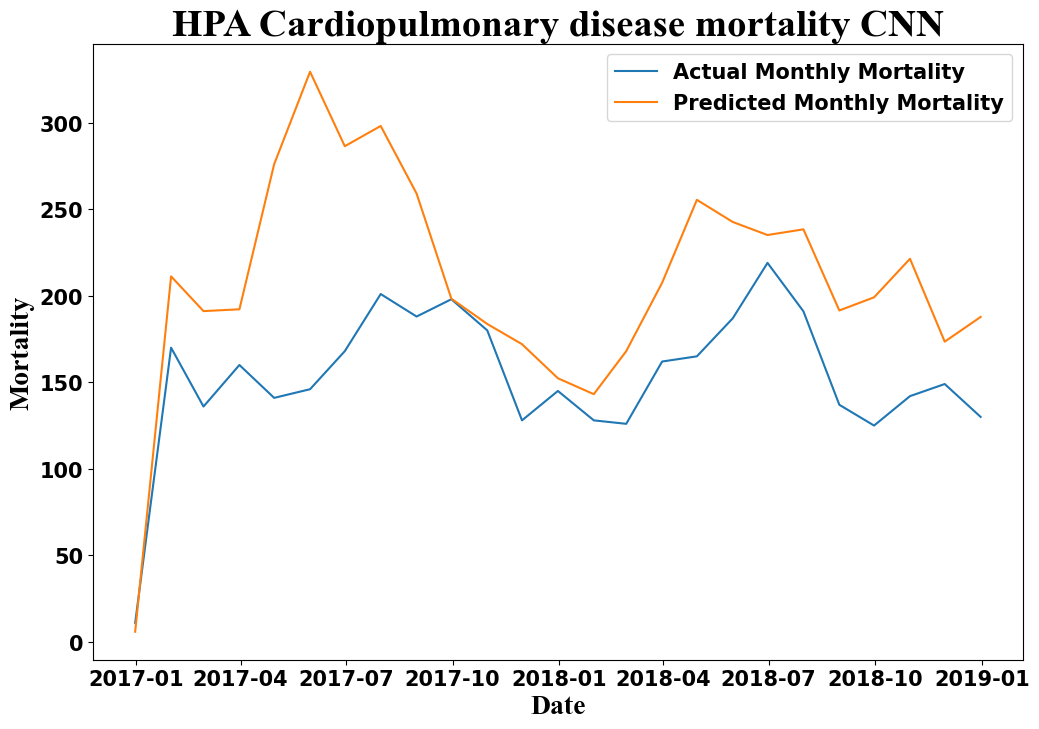

In [13]:
# Plot actual vs predicted monthly mortality
rcParams['font.weight'] = 'bold'
rcParams['font.size'] = '15'
plt.figure(figsize=(12, 8))

# Plot actual vs predicted monthly mortality
plt.plot(df_actual_monthly.index, df_actual_monthly.values, label='Actual Monthly Mortality')
plt.plot(monthly_predictions.index, monthly_predictions['predicted_mortality'].values, label='Predicted Monthly Mortality')

# Customize the x-axis labels
#plt.xticks(rotation=90)

plt.ylabel('Mortality', fontname="Times New Roman", size=20, fontweight="bold")
plt.xlabel('Date', fontname="Times New Roman", size=20, fontweight="bold")
plt.title('HPA Cardiopulmonary disease mortality CNN', fontname="Times New Roman", size=28, fontweight="bold")

# Set legend properties
legend_properties = {'weight': 'bold'}
plt.legend(prop=legend_properties)

plt.show()

In [14]:
mean_absolute_error(df_actual_monthly, monthly_predictions)

55.862782135009766

In [15]:
rmse = sqrt(mean_squared_error(df_actual_monthly, monthly_predictions))
print(rmse)

70.63865505743338


# CNN FOR SHAP

C:\Users\User\anaconda3\envs\MyChatBot\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


  0%|          | 0/100 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
8838/8838 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step


  1%|          | 1/100 [00:42<1:10:17, 42.60s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
8838/8838 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step


  2%|▏         | 2/100 [01:09<54:53, 33.61s/it]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
8838/8838 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step


  3%|▎         | 3/100 [01:52<1:01:07, 37.81s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
8838/8838 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step


  4%|▍         | 4/100 [02:35<1:03:29, 39.68s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
8838/8838 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step


  5%|▌         | 5/100 [03:17<1:04:26, 40.70s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
8838/8838 ━━━━━━━━━━━━━━━━━━━━ 22s 2ms/step


  6%|▌         | 6/100 [04:00<1:04:46, 41.35s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
8838/8838 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step


  7%|▋         | 7/100 [04:42<1:04:40, 41.73s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
8838/8838 ━━━━━━━━━━━━━━━━━━━━ 22s 3ms/step


  8%|▊         | 8/100 [05:11<57:43, 37.65s/it]  

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
8838/8838 ━━━━━━━━━━━━━━━━━━━━ 23s 3ms/step


  9%|▉         | 9/100 [05:41<53:23, 35.21s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
8838/8838 ━━━━━━━━━━━━━━━━━━━━ 23s 3ms/step


 10%|█         | 10/100 [06:24<56:13, 37.48s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
8838/8838 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step


 11%|█         | 11/100 [07:06<57:52, 39.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
8838/8838 ━━━━━━━━━━━━━━━━━━━━ 24s 3ms/step


 12%|█▏        | 12/100 [07:37<53:20, 36.37s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
8838/8838 ━━━━━━━━━━━━━━━━━━━━ 22s 3ms/step


 13%|█▎        | 13/100 [08:05<49:23, 34.06s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
8838/8838 ━━━━━━━━━━━━━━━━━━━━ 22s 3ms/step


 14%|█▍        | 14/100 [08:48<52:30, 36.63s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
8838/8838 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step


 15%|█▌        | 15/100 [09:30<54:25, 38.42s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
8838/8838 ━━━━━━━━━━━━━━━━━━━━ 23s 3ms/step


 16%|█▌        | 16/100 [10:13<55:30, 39.65s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
8838/8838 ━━━━━━━━━━━━━━━━━━━━ 22s 3ms/step


 17%|█▋        | 17/100 [10:55<56:03, 40.53s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
8838/8838 ━━━━━━━━━━━━━━━━━━━━ 22s 2ms/step


 18%|█▊        | 18/100 [11:38<56:10, 41.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
8838/8838 ━━━━━━━━━━━━━━━━━━━━ 22s 2ms/step


 19%|█▉        | 19/100 [12:20<56:02, 41.51s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
8838/8838 ━━━━━━━━━━━━━━━━━━━━ 22s 2ms/step


 20%|██        | 20/100 [13:03<55:45, 41.82s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
8838/8838 ━━━━━━━━━━━━━━━━━━━━ 22s 2ms/step


 21%|██        | 21/100 [13:45<55:18, 42.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
8838/8838 ━━━━━━━━━━━━━━━━━━━━ 23s 3ms/step


 22%|██▏       | 22/100 [14:28<54:46, 42.14s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
8838/8838 ━━━━━━━━━━━━━━━━━━━━ 22s 2ms/step


 23%|██▎       | 23/100 [14:56<48:45, 38.00s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
8838/8838 ━━━━━━━━━━━━━━━━━━━━ 22s 3ms/step


 24%|██▍       | 24/100 [15:39<49:52, 39.38s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
8838/8838 ━━━━━━━━━━━━━━━━━━━━ 23s 3ms/step


 25%|██▌       | 25/100 [16:21<50:24, 40.32s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
8838/8838 ━━━━━━━━━━━━━━━━━━━━ 23s 3ms/step


 26%|██▌       | 26/100 [17:04<50:36, 41.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
8838/8838 ━━━━━━━━━━━━━━━━━━━━ 23s 3ms/step


 27%|██▋       | 27/100 [17:46<50:26, 41.47s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
8838/8838 ━━━━━━━━━━━━━━━━━━━━ 25s 3ms/step


 28%|██▊       | 28/100 [18:29<50:08, 41.78s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
8838/8838 ━━━━━━━━━━━━━━━━━━━━ 23s 3ms/step


 29%|██▉       | 29/100 [19:12<49:42, 42.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
8838/8838 ━━━━━━━━━━━━━━━━━━━━ 23s 3ms/step


 30%|███       | 30/100 [19:54<49:13, 42.19s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
8838/8838 ━━━━━━━━━━━━━━━━━━━━ 24s 3ms/step


 31%|███       | 31/100 [20:37<48:37, 42.28s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
8838/8838 ━━━━━━━━━━━━━━━━━━━━ 23s 3ms/step


 32%|███▏      | 32/100 [21:19<48:03, 42.40s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
8838/8838 ━━━━━━━━━━━━━━━━━━━━ 23s 3ms/step


 33%|███▎      | 33/100 [22:02<47:24, 42.46s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
8838/8838 ━━━━━━━━━━━━━━━━━━━━ 23s 3ms/step


 34%|███▍      | 34/100 [22:45<46:45, 42.51s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
8838/8838 ━━━━━━━━━━━━━━━━━━━━ 23s 3ms/step


 35%|███▌      | 35/100 [23:27<46:03, 42.52s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
8838/8838 ━━━━━━━━━━━━━━━━━━━━ 23s 3ms/step


 36%|███▌      | 36/100 [23:56<41:07, 38.56s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
8838/8838 ━━━━━━━━━━━━━━━━━━━━ 24s 3ms/step


 37%|███▋      | 37/100 [24:39<41:43, 39.73s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
8838/8838 ━━━━━━━━━━━━━━━━━━━━ 24s 3ms/step


 38%|███▊      | 38/100 [25:09<37:59, 36.77s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
8838/8838 ━━━━━━━━━━━━━━━━━━━━ 23s 3ms/step


 39%|███▉      | 39/100 [25:51<39:08, 38.50s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
8838/8838 ━━━━━━━━━━━━━━━━━━━━ 22s 2ms/step


 40%|████      | 40/100 [26:34<39:44, 39.75s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
8838/8838 ━━━━━━━━━━━━━━━━━━━━ 22s 2ms/step


 41%|████      | 41/100 [27:03<35:49, 36.43s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
8838/8838 ━━━━━━━━━━━━━━━━━━━━ 22s 2ms/step


 42%|████▏     | 42/100 [27:45<37:01, 38.31s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
8838/8838 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step


 43%|████▎     | 43/100 [28:13<33:15, 35.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
8838/8838 ━━━━━━━━━━━━━━━━━━━━ 22s 3ms/step


 44%|████▍     | 44/100 [28:55<34:49, 37.32s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
8838/8838 ━━━━━━━━━━━━━━━━━━━━ 22s 3ms/step


 45%|████▌     | 45/100 [29:25<32:01, 34.94s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
8838/8838 ━━━━━━━━━━━━━━━━━━━━ 22s 3ms/step


 46%|████▌     | 46/100 [29:53<29:46, 33.08s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
8838/8838 ━━━━━━━━━━━━━━━━━━━━ 22s 3ms/step


 47%|████▋     | 47/100 [30:36<31:43, 35.91s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
8838/8838 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step


 48%|████▊     | 48/100 [31:18<32:49, 37.88s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
8838/8838 ━━━━━━━━━━━━━━━━━━━━ 22s 2ms/step


 49%|████▉     | 49/100 [31:46<29:41, 34.94s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
8838/8838 ━━━━━━━━━━━━━━━━━━━━ 22s 2ms/step


 50%|█████     | 50/100 [32:29<31:01, 37.23s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
8838/8838 ━━━━━━━━━━━━━━━━━━━━ 22s 3ms/step


 51%|█████     | 51/100 [32:58<28:24, 34.79s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
8838/8838 ━━━━━━━━━━━━━━━━━━━━ 22s 3ms/step


 52%|█████▏    | 52/100 [33:41<29:43, 37.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
8838/8838 ━━━━━━━━━━━━━━━━━━━━ 23s 3ms/step


 53%|█████▎    | 53/100 [34:11<27:21, 34.93s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
8838/8838 ━━━━━━━━━━━━━━━━━━━━ 23s 3ms/step


 54%|█████▍    | 54/100 [34:53<28:31, 37.21s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
8838/8838 ━━━━━━━━━━━━━━━━━━━━ 23s 3ms/step


 55%|█████▌    | 55/100 [35:22<26:05, 34.79s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
8838/8838 ━━━━━━━━━━━━━━━━━━━━ 23s 3ms/step


 56%|█████▌    | 56/100 [36:05<27:11, 37.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
8838/8838 ━━━━━━━━━━━━━━━━━━━━ 23s 3ms/step


 57%|█████▋    | 57/100 [36:47<27:45, 38.72s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
8838/8838 ━━━━━━━━━━━━━━━━━━━━ 23s 3ms/step


 58%|█████▊    | 58/100 [37:30<27:54, 39.87s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
8838/8838 ━━━━━━━━━━━━━━━━━━━━ 24s 3ms/step


 59%|█████▉    | 59/100 [38:12<27:47, 40.67s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
8838/8838 ━━━━━━━━━━━━━━━━━━━━ 23s 3ms/step


 60%|██████    | 60/100 [38:55<27:30, 41.25s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
8838/8838 ━━━━━━━━━━━━━━━━━━━━ 23s 3ms/step


 61%|██████    | 61/100 [39:37<27:03, 41.64s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
8838/8838 ━━━━━━━━━━━━━━━━━━━━ 24s 3ms/step


 62%|██████▏   | 62/100 [40:20<26:31, 41.89s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
8838/8838 ━━━━━━━━━━━━━━━━━━━━ 24s 3ms/step


 63%|██████▎   | 63/100 [41:02<25:55, 42.05s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
8838/8838 ━━━━━━━━━━━━━━━━━━━━ 23s 3ms/step


 64%|██████▍   | 64/100 [41:45<25:18, 42.18s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
8838/8838 ━━━━━━━━━━━━━━━━━━━━ 23s 3ms/step


 65%|██████▌   | 65/100 [42:14<22:20, 38.31s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
8838/8838 ━━━━━━━━━━━━━━━━━━━━ 23s 3ms/step


 66%|██████▌   | 66/100 [42:57<22:25, 39.57s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
8838/8838 ━━━━━━━━━━━━━━━━━━━━ 22s 2ms/step


 67%|██████▋   | 67/100 [43:39<22:15, 40.46s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
8838/8838 ━━━━━━━━━━━━━━━━━━━━ 24s 3ms/step


 68%|██████▊   | 68/100 [44:22<21:55, 41.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
8838/8838 ━━━━━━━━━━━━━━━━━━━━ 24s 3ms/step


 69%|██████▉   | 69/100 [45:04<21:27, 41.55s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
8838/8838 ━━━━━━━━━━━━━━━━━━━━ 23s 3ms/step


 70%|███████   | 70/100 [45:34<18:56, 37.89s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
8838/8838 ━━━━━━━━━━━━━━━━━━━━ 23s 3ms/step


 71%|███████   | 71/100 [46:16<18:58, 39.27s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
8838/8838 ━━━━━━━━━━━━━━━━━━━━ 22s 3ms/step


 72%|███████▏  | 72/100 [46:59<18:47, 40.25s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
8838/8838 ━━━━━━━━━━━━━━━━━━━━ 23s 3ms/step


 73%|███████▎  | 73/100 [47:41<18:24, 40.92s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
8838/8838 ━━━━━━━━━━━━━━━━━━━━ 23s 3ms/step


 74%|███████▍  | 74/100 [48:24<17:56, 41.42s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
8838/8838 ━━━━━━━━━━━━━━━━━━━━ 24s 3ms/step


 75%|███████▌  | 75/100 [48:54<15:54, 38.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
8838/8838 ━━━━━━━━━━━━━━━━━━━━ 24s 3ms/step


 76%|███████▌  | 76/100 [49:37<15:47, 39.48s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
8838/8838 ━━━━━━━━━━━━━━━━━━━━ 24s 3ms/step


 77%|███████▋  | 77/100 [50:19<15:28, 40.36s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
8838/8838 ━━━━━━━━━━━━━━━━━━━━ 24s 3ms/step


 78%|███████▊  | 78/100 [51:02<15:02, 41.00s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
8838/8838 ━━━━━━━━━━━━━━━━━━━━ 24s 3ms/step


 79%|███████▉  | 79/100 [51:44<14:30, 41.44s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
8838/8838 ━━━━━━━━━━━━━━━━━━━━ 22s 2ms/step


 80%|████████  | 80/100 [52:27<13:55, 41.77s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
8838/8838 ━━━━━━━━━━━━━━━━━━━━ 24s 3ms/step


 81%|████████  | 81/100 [53:10<13:18, 42.03s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
8838/8838 ━━━━━━━━━━━━━━━━━━━━ 24s 3ms/step


 82%|████████▏ | 82/100 [53:52<12:39, 42.18s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
8838/8838 ━━━━━━━━━━━━━━━━━━━━ 23s 3ms/step


 83%|████████▎ | 83/100 [54:35<11:58, 42.28s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
8838/8838 ━━━━━━━━━━━━━━━━━━━━ 24s 3ms/step


 84%|████████▍ | 84/100 [55:17<11:17, 42.35s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
8838/8838 ━━━━━━━━━━━━━━━━━━━━ 24s 3ms/step


 85%|████████▌ | 85/100 [56:00<10:36, 42.41s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
8838/8838 ━━━━━━━━━━━━━━━━━━━━ 23s 3ms/step


 86%|████████▌ | 86/100 [56:42<09:53, 42.41s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
8838/8838 ━━━━━━━━━━━━━━━━━━━━ 25s 3ms/step


 87%|████████▋ | 87/100 [57:25<09:11, 42.43s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
8838/8838 ━━━━━━━━━━━━━━━━━━━━ 24s 3ms/step


 88%|████████▊ | 88/100 [58:07<08:29, 42.45s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
8838/8838 ━━━━━━━━━━━━━━━━━━━━ 23s 3ms/step


 89%|████████▉ | 89/100 [58:50<07:47, 42.47s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
8838/8838 ━━━━━━━━━━━━━━━━━━━━ 24s 3ms/step


 90%|█████████ | 90/100 [59:32<07:04, 42.48s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
8838/8838 ━━━━━━━━━━━━━━━━━━━━ 23s 3ms/step


 91%|█████████ | 91/100 [1:00:15<06:22, 42.49s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
8838/8838 ━━━━━━━━━━━━━━━━━━━━ 23s 3ms/step


 92%|█████████▏| 92/100 [1:00:57<05:40, 42.53s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
8838/8838 ━━━━━━━━━━━━━━━━━━━━ 23s 3ms/step


 93%|█████████▎| 93/100 [1:01:27<04:30, 38.70s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
8838/8838 ━━━━━━━━━━━━━━━━━━━━ 24s 3ms/step


 94%|█████████▍| 94/100 [1:02:09<03:59, 39.86s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
8838/8838 ━━━━━━━━━━━━━━━━━━━━ 22s 2ms/step


 95%|█████████▌| 95/100 [1:02:52<03:23, 40.68s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
8838/8838 ━━━━━━━━━━━━━━━━━━━━ 24s 3ms/step


 96%|█████████▌| 96/100 [1:03:35<02:44, 41.23s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
8838/8838 ━━━━━━━━━━━━━━━━━━━━ 23s 3ms/step


 97%|█████████▋| 97/100 [1:04:17<02:04, 41.61s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
8838/8838 ━━━━━━━━━━━━━━━━━━━━ 23s 3ms/step


 98%|█████████▊| 98/100 [1:04:46<01:15, 37.87s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
8838/8838 ━━━━━━━━━━━━━━━━━━━━ 24s 3ms/step


 99%|█████████▉| 99/100 [1:05:29<00:39, 39.23s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
8838/8838 ━━━━━━━━━━━━━━━━━━━━ 25s 3ms/step


100%|██████████| 100/100 [1:06:00<00:00, 39.60s/it]


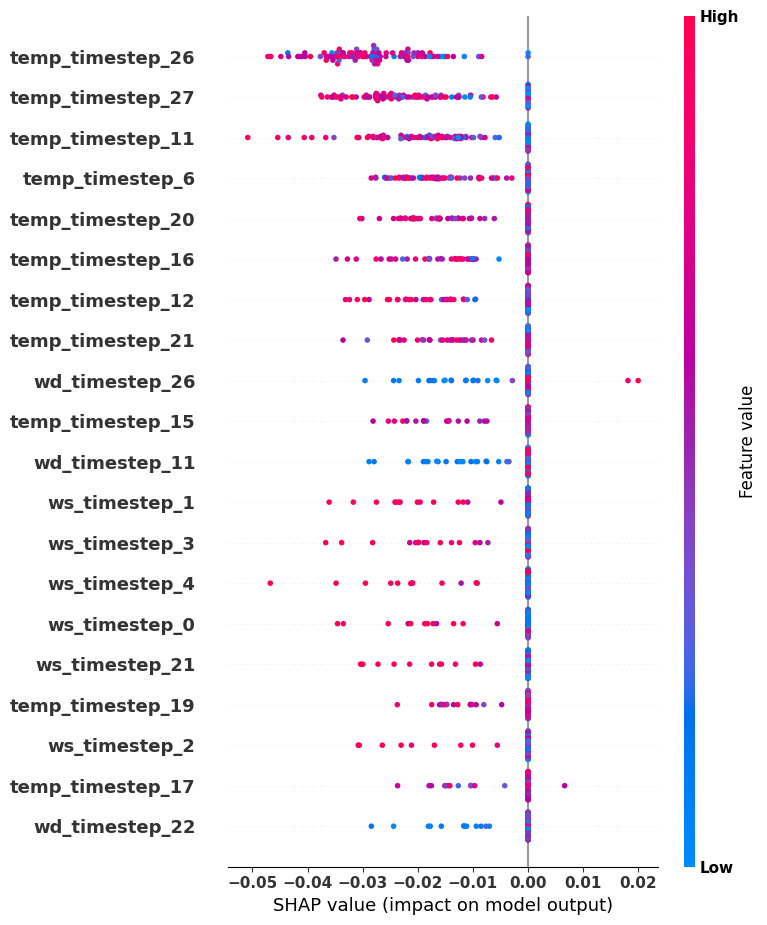

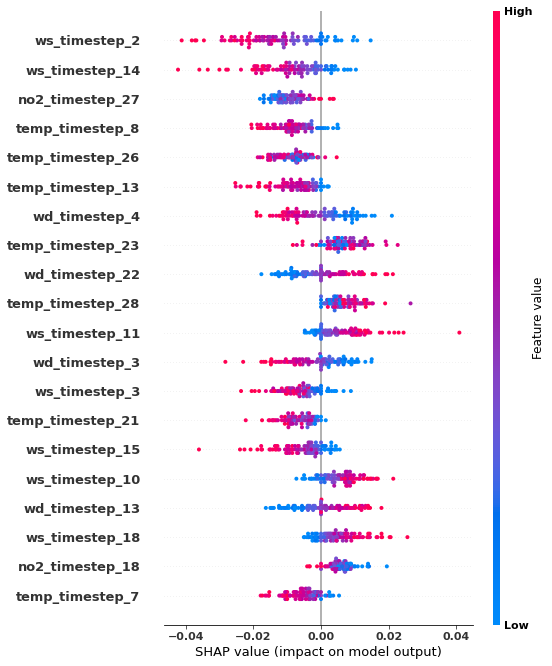

In [16]:
import shap 
# Sample a subset of the test set 
X_test_sample = X_test[:100] # Use a small sample for demonstration 
# Flatten the data for SHAP 
X_train_flattened = X_train.reshape((X_train.shape[0], X_train.shape[1] * X_train.shape[2])) 
X_test_sample_flattened = X_test_sample.reshape((X_test_sample.shape[0], X_test_sample.shape[1] * X_test_sample.shape[2]))

# Create a SHAP KernelExplainer 
explainer = shap.KernelExplainer( lambda x: model.predict(x.reshape((x.shape[0], n_steps, X.shape[2]))).reshape(-1), # Ensure the output is 1D 
                                 X_train_flattened[:100] ) 
# Calculate SHAP values for the test sample 
shap_values = explainer.shap_values(X_test_sample_flattened)

# Feature names (flattened time steps and features) 
flattened_feature_names = [f"{feature}_timestep_{i}" for i in range(n_steps) for feature in features.columns] 
# Ensure the length of feature names matches the number of features 
assert len(flattened_feature_names) == X_test_sample_flattened.shape[1], "Feature names length mismatch." 
# Plot summary plot of SHAP values 
shap.summary_plot(shap_values, X_test_sample_flattened, feature_names=flattened_feature_names)

When you use SHAP (SHapley Additive exPlanations) to interpret your LSTM model, you're generating explanations for the predictions by measuring the contribution of each feature.

To visualize the SHAP values in the code you provided, you’re effectively explaining the importance of each feature in predicting death_count. Here's a breakdown of how to interpret the SHAP summary plot:

Feature Importance: The plot shows the impact of each feature on the model’s output. Features are sorted by importance with the most influential ones at the top.

Feature Names: Each feature name includes a timestep and the original feature name (e.g., temperature_timestep_1). This helps you understand which specific times and features are most important.

SHAP Values: Each point represents a SHAP value for a feature at a particular timestep, indicating how much that feature and timestep contributed to increasing or decreasing the predicted death_count.

Color: The color of each point typically represents the value of the feature from low (blue) to high (red). This helps you see how feature values are associated with higher or lower predictions.

# CNN WITH ATTENTION

Epoch 1/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0361 
Epoch 2/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0197 
Epoch 3/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0213    
Epoch 4/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0204  
Epoch 5/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0196 
Epoch 6/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0192 
Epoch 7/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0212 
Epoch 8/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0188 
Epoch 9/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0178 
Epoch 10/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0184    
Epoch 11/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0213 
Epoch 12/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0203 
Epoch 13/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0180   
Epoch 14/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0170 
Epoch 15/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0

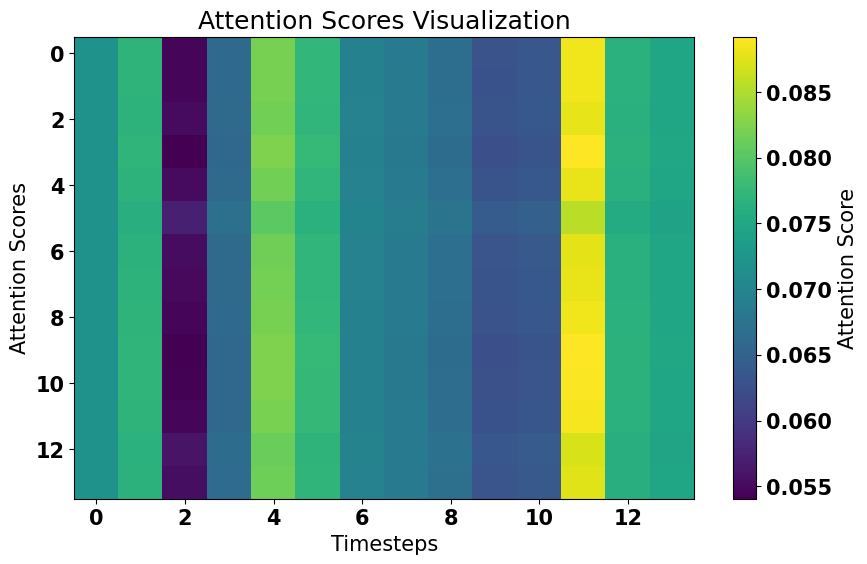

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.models import Model
from keras.layers import Conv1D, Dense, Input, Flatten, Dot, Softmax, MaxPooling1D
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

# Define the attention mechanism
def attention_layer(inputs):
    query = Dense(1, use_bias=False)(inputs)  # Query layer
    keys = Dense(1, use_bias=False)(inputs)   # Key layer
    values = Dense(1, use_bias=False)(inputs) # Value layer

    # Compute attention scores
    scores = Dot(axes=[2, 2])([query, keys])  # Shape: (batch_size, n_steps, 1)
    scores = Softmax()(scores)  # Normalize scores
    context_vector = Dot(axes=[1, 1])([scores, values])  # Shape: (batch_size, 1, features)

    return context_vector, scores

# Define the CNN model
def build_cnn_model(n_steps, n_features):
    inputs = Input(shape=(n_steps, n_features))
    x = Conv1D(filters=64, kernel_size=3, activation='relu')(inputs)
    x = MaxPooling1D(pool_size=2)(x)
    context_vector, attention_scores = attention_layer(x)  # Apply attention mechanism and capture scores
    x = Flatten()(context_vector)
    x = Dense(50, activation='relu')(x)
    outputs = Dense(1)(x)  # Output is just the prediction
    model = tf.keras.models.Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='mse')
    return model, attention_scores  # Return attention scores for later use

# Load and preprocess data
df = pd.read_csv('C:/Users/User/Documents/GitHub/Health-impacts-of-air-pollution/MortData/GertPollMortAll.csv', sep=';', header=0, index_col=0, parse_dates=True)
df_cleaned = df.dropna()
target = 'death_count'
features = df_cleaned.drop(columns=[target])

scaler_features = MinMaxScaler(feature_range=(0, 1))
scaler_target = MinMaxScaler(feature_range=(0, 1))
scaled_features = scaler_features.fit_transform(features)
scaled_target = scaler_target.fit_transform(df_cleaned[[target]])

# Create sequences
def create_sequences(data, target_data, n_steps):
    X, y = [], []
    for i in range(len(data) - n_steps):
        X.append(data[i:i + n_steps])
        y.append(target_data[i + n_steps])
    return np.array(X), np.array(y)

n_steps = 30
X, y = create_sequences(scaled_features, scaled_target, n_steps)
X = X.reshape((X.shape[0], X.shape[1], X.shape[2]))

train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Build and train the CNN model
model, attention_scores = build_cnn_model(n_steps, X.shape[2])
history = model.fit(X_train, y_train, epochs=30, batch_size=32, verbose=1)

# Make predictions
predictions = model.predict(X_test)

# Rescale the predictions
daily_predictions_rescaled = scaler_target.inverse_transform(predictions)

# Evaluate the model to get attention scores
example_input = X_test[:1]  # Use a sample from your test data
attention_model = tf.keras.models.Model(inputs=model.input, outputs=attention_scores)
attention_scores_sample = attention_model.predict(example_input)

# Plot the attention scores
plt.figure(figsize=(10, 6))
plt.imshow(attention_scores_sample[0], aspect='auto', cmap='viridis')
plt.colorbar(label='Attention Score')
plt.xlabel('Timesteps')
plt.ylabel('Attention Scores')
plt.title('Attention Scores Visualization')
plt.show()

The reason your time steps end at 12 instead of the expected 30 likely has to do with the max pooling operation in the CNN. When you use MaxPooling1D with a pool size of 2, it reduces the number of time steps by half with each pooling operation.

Here’s a bit more detail:

Original Time Steps: Your input sequence length is 30.

After Convolution: The length remains the same (30).

After MaxPooling1D(pool_size=2): This reduces the length to 15.